# Analyze Samples
## Imports

In [1]:
import os
import random

from tlib import tlearn, tgeo, tutils
from projects.testbed18 import config, utils

from api_coverages import get_coverage

%load_ext autoreload
%autoreload 2

## Configuration

In [2]:
#collection = 'collections/s2_anthropo'
collection = 'collections/s2_investigative'
#bbox = [16.7, 59.7, 16.825, 59.825] # -> 1250 x 1250 pixels
#bbox = [16.8, 59.8, 16.8251, 59.825] # -> 250 x 250 pixels
#bbox = [20.27080771398277, 66.45825882626778, 20.495119661234394, 66.55002311657806] # paper figure 8
#bbox = [10.434810477469897, 62.019114499434934, 10.836427562826682, 62.1989645072601] # paper figure 9 (2017)
#bbox = [10.434810477469897, 62.019114499434934, 10.836427562826682, 62.1989645072601] # paper figure 9 (2020)
#bbox = [26.12659400833689, 65.34754243953564, 26.341300676504012, 65.43979470854401] # paper figure 10
bbox = [20.27, 66.45, 20.39, 66.57]
bands = None  # e.g.'blue, green, red'

## Download data from API Coverages

In [3]:
collection_url = config.server_url + collection

In [4]:
result = get_coverage(collection_url, bbox, bands)
dataset = result.open()

Requesting coverage from 'https://18.testbed.dev.52north.org/geodatacube/collections/s2_investigative/coverage?f=GeoTIFF&bbox=20.27,66.45,20.39,66.57'


In [7]:
result

In [8]:
#import rasterio
#src_temp = rasterio.open(result)

In [9]:
#print(src_temp.read())
#src_temp.close()

In [10]:
images = dataset.read()

In [6]:
print(type(result))
print(type(dataset)) # rasterio.open(file)
#print(type(images))

<class 'rasterio.io.MemoryFile'>
<class 'rasterio.io.DatasetReader'>


In [11]:
# ToDo: add in pygeoapi_odc_provider
channel_names = dataset.descriptions
#titles = ['blue', 'green', 'red', 'vegetation_red_edge1', 'vegetation_red_edge2', 'vegetation_red_edge3',
#          'nir', 'narrow_nir', 'swir1', 'swir2']

In [12]:
band = dataset.read(2) # index starting at 1

In [13]:
print('Shape:', band.shape)
print('Array:\n', band)

Shape: (1199, 1200)
Array:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Setup Files and Plotter

In [10]:
channel_indices = {'B2': 0, 'B3': 1, 'B4': 2, 'B5': 3, 'B6': 4, 'B7': 5, 'B8': 6, 'B8A': 7, 'B11': 8, 'B12': 9}

In [15]:
files = ['/home/martin/Projekte/OGC_Testbed-18/data/anthroprotect/investigative/inv_hydroelectric-letsi_2019-07-01-2019-08-30.tif']

In [14]:
trainer = utils.load_trainer()

In [79]:
trainer.datamodule.dataset_kwargs

{'channels': None,
 'x_normalization': (0, 10000),
 'clip_range': (0, 1),
 'y_normalization': None,
 'n_classes': 1,
 'use_rasterio': True,
 'rgb_channels': [2, 1, 0],
 'val_range': (0, 1024)}

In [77]:
dataset_from_datamodule = trainer.datamodule.get_dataset(files)

In [83]:
dataset_from_datamodule.use_rasterio

True

## Predict activation map

### From file

In [71]:
unet_map = utils.predict_activation_maps(files[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


In [73]:
unet_map[0].shape

torch.Size([3, 1013, 1008])

In [74]:
unet_map.shape

torch.Size([1, 3, 1013, 1008])

In [75]:
unet_map[0][0]

tensor([[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ..., -1., -1., -1.]])

In [70]:
#plt.imshow(unet_map[0][0], clim=(-1, 1))
#plt.axis(False)

### From MemoryFile (API)

In [76]:
prediction = utils.predict_activation_maps(result)

  0%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/martin/Projekte/OGC_Testbed-18/software/venv-testbed-18/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 160, in default_collate
    return elem_type({key: default_collate([d[key] for d in batch]) for key in elem})
  File "/home/martin/Projekte/OGC_Testbed-18/software/venv-testbed-18/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 160, in <dictcomp>
    return elem_type({key: default_collate([d[key] for d in batch]) for key in elem})
  File "/home/martin/Projekte/OGC_Testbed-18/software/venv-testbed-18/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 183, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'rasterio.io.MemoryFile'>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/martin/Projekte/OGC_Testbed-18/software/venv-testbed-18/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/martin/Projekte/OGC_Testbed-18/software/venv-testbed-18/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/home/martin/Projekte/OGC_Testbed-18/software/venv-testbed-18/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 163, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/home/martin/Projekte/OGC_Testbed-18/software/venv-testbed-18/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 163, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/home/martin/Projekte/OGC_Testbed-18/software/venv-testbed-18/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 183, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'rasterio.io.MemoryFile'>


## Plot Sample

In [16]:
s2_plotter_generic = utils.GenericS2Plotter()

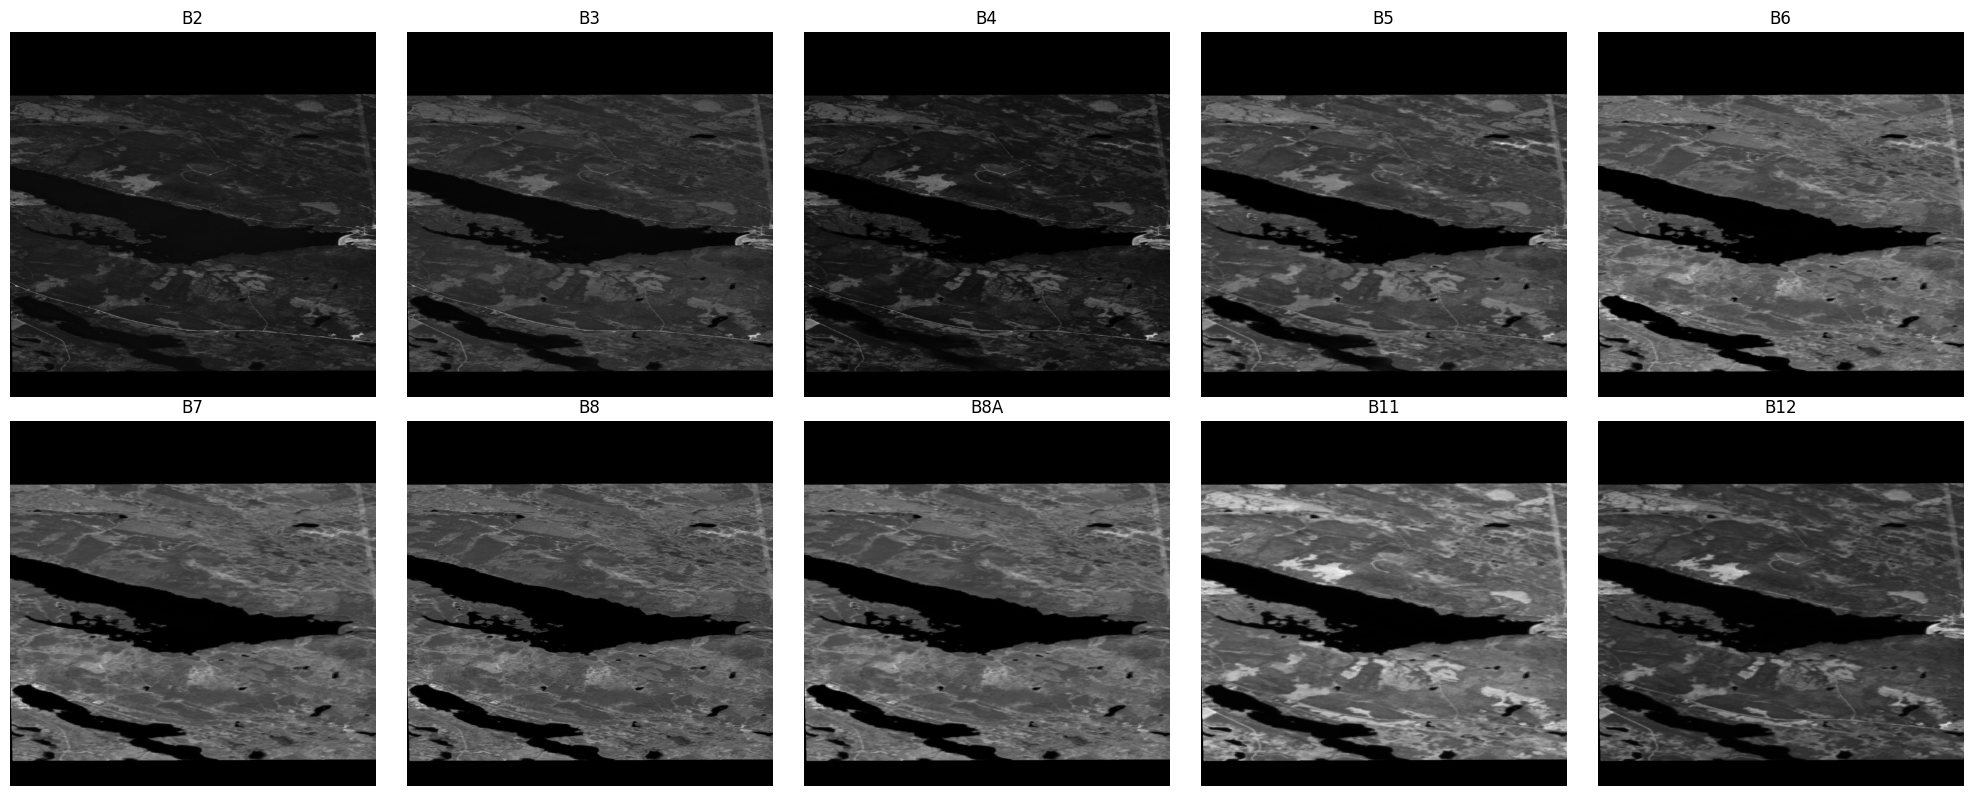

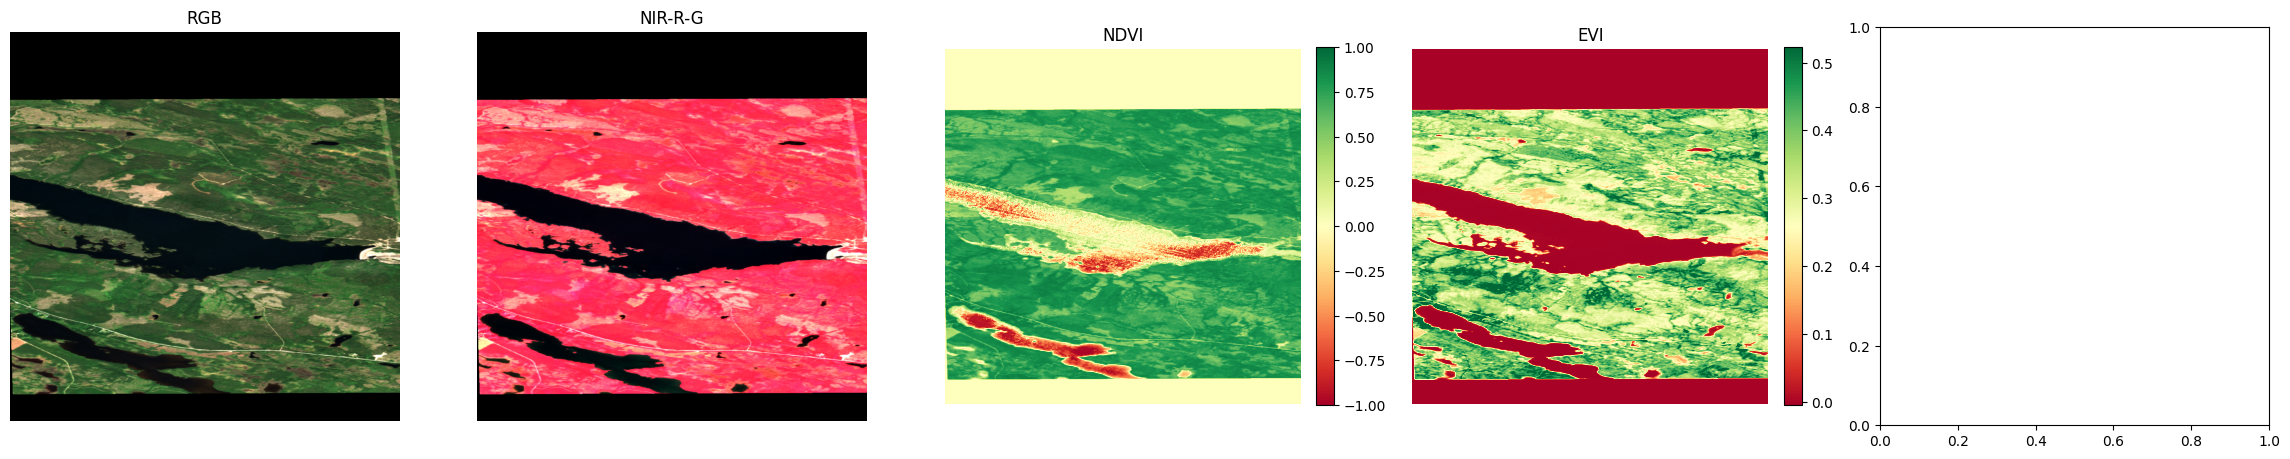

In [18]:
s2_plotter_generic.plot(
    images,
    figsize=(4 * 5, 4 * 2)
)

---

## All Files to RGB Tiff
Note: If you do not have a trained model, yet, you can ignore some of the plot_kwargs! To plot them, you need to predict the image.

In [ ]:
output_folder = os.path.join(config.working_dir, 'rgbs')  # os.path.join(utils.load_trainer().log_dir, 'rgbs')

In [ ]:
# plotter
s2_plotter.val_range_s2 = (0, 2**10.5)
s2_plotter.to_tif(
    *files,
    output_folder=output_folder,
    
    plot_rgb=True,
    #plot_false_colors=True,
    #plot_channels=['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'],
    #plot_ndvi=True,
    #plot_evi=True,
    #plot_scl=True,
    #plot_lcs=['CORINE', 'MODIS_1', 'CGLS', 'GlobCover'],  # ['CORINE', 'MODIS_1', 'CGLS', 'GlobCover']
    #plot_masks=['BB'],#['ROI', 'Valid_Area'],  # ['ROI', 'Valid_Area']
)

asos_plotter.to_tif(
    *files,
    output_folder=output_folder,
    
    plot_unet_maps=True,
    #plot_all_unet_maps=True,
    plot_sensitivities=True,
    #plot_osms=True,

    batch_size=batch_size,
)